In [1]:
import pandas as pd
import polars as pl
import os 

In [2]:
df = pd.read_parquet('C:/Users/srabh/OneDrive/Documents/Jane_Street_Data_Challenge/train.parquet/partition_id=9/part-0.parquet')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

def analyze_all_symbols(df: pd.DataFrame):
    """
    Analyse tous les symbols et leurs données chronologiques
    Create a dictionary of data frames per symbol
    
    Args:
        df: DataFrame contenant les données; original data frame e.g. part-0.parquet
    Returns:
        Dict avec les données groupées par symbol
    """
    # Obtenir la liste unique des symbol_ids
    unique_symbols = sorted(df['symbol_id'].unique())
    print(f"Nombre total de symbols: {len(unique_symbols)}")
    
    # Dictionnaire pour stocker les résultats
    symbol_data = {}
    
    # Pour chaque symbol_id
    for symbol in tqdm(unique_symbols):
        # Filtrer les données pour ce symbol
        symbol_df = (df[df['symbol_id'] == symbol]
                    .sort_values('date_id')
                    .copy())
        
        # Stocker dans le dictionnaire
        symbol_data[symbol] = symbol_df
        
    return symbol_data

def display_symbol_timeline(symbol_data, n_symbols=5, n_dates=5):
    """
    Affiche les premières dates pour plusieurs symbols
    """
    for symbol in list(symbol_data.keys())[:n_symbols]:
        print(f"\nSymbol ID: {symbol}")
        print("-" * 50)
        print(symbol_data[symbol]
              .sort_values('date_id')
              [['date_id', 'symbol_id', 'weight'] + 
               [col for col in symbol_data[symbol].columns if col.startswith('feature')]]
              .head(n_dates))

def plot_feature_evolution(symbol_data, feature_name='feature_05', n_symbols=5):
    """
    Plot l'évolution d'une feature pour plusieurs symbols
    """
    plt.figure(figsize=(15, 8))
    
    for symbol in list(symbol_data.keys())[:n_symbols]:
        data = symbol_data[symbol].sort_values('date_id')
        plt.plot(data['date_id'], data[feature_name], 
                label=f'Symbol {symbol}', alpha=0.7)
    
    plt.title(f'Évolution de {feature_name} par Symbol')
    plt.xlabel('Date ID')
    plt.ylabel('Valeur')
    plt.legend()
    plt.grid(True)
    plt.show()

def get_symbol_statistics(symbol_data):
    """
    Calcule les statistiques pour chaque symbol
    """
    stats = []
    
    for symbol, data in symbol_data.items():
        stats.append({
            'symbol_id': symbol,
            'n_dates': len(data),
            'mean_weight': data['weight'].mean(),
            'min_date': data['date_id'].min(),
            'max_date': data['date_id'].max(),
            'n_features': len([col for col in data.columns if col.startswith('feature')])
        })
    
    return pd.DataFrame(stats)

# Fonction principale pour exécuter toute l'analyse
def run_complete_analysis(df, n_display_symbols=5, feature_to_plot='feature_05'):
    """
    Exécute l'analyse complète des données
    """
    print("1. Groupement des données par symbol...")
    symbol_data = analyze_all_symbols(df)
    
    print("\n2. Aperçu des données chronologiques:")
    display_symbol_timeline(symbol_data, n_symbols=n_display_symbols)
    
    print("\n3. Statistiques par symbol:")
    stats_df = get_symbol_statistics(symbol_data)
    print(stats_df.head())
    
    print("\n4. Visualisation de l'évolution d'une feature:")
    plot_feature_evolution(symbol_data, feature_name=feature_to_plot, 
                         n_symbols=n_display_symbols)
    
    return symbol_data, stats_df

1. Groupement des données par symbol...
Nombre total de symbols: 39


100%|██████████| 39/39 [00:16<00:00,  2.30it/s]



2. Aperçu des données chronologiques:

Symbol ID: 0
--------------------------------------------------
       date_id  symbol_id    weight  feature_00  feature_01  feature_02  \
0         1530          0  3.084694    1.153571    1.563784    0.697396   
17871     1530          0  3.084694    0.684324   -1.104674    0.785371   
37        1530          0  3.084694    1.526388    1.685531    0.605749   
74        1530          0  3.084694    1.340964    1.983167    0.265608   
111       1530          0  3.084694    1.524939    1.978163    0.512771   

       feature_03  feature_04  feature_05  feature_06  ...  feature_69  \
0        0.756759    2.580965    0.171311    1.126353  ...    0.493488   
17871    0.785760   -1.000620   -0.351899    0.175980  ...   -0.434310   
37       1.037362    2.191367    0.256185    0.915194  ...    0.557781   
74       0.499131    2.603905    0.556939    3.110481  ...    0.355192   
111      0.693869    2.607875    0.650951    2.096772  ...    0.360436   



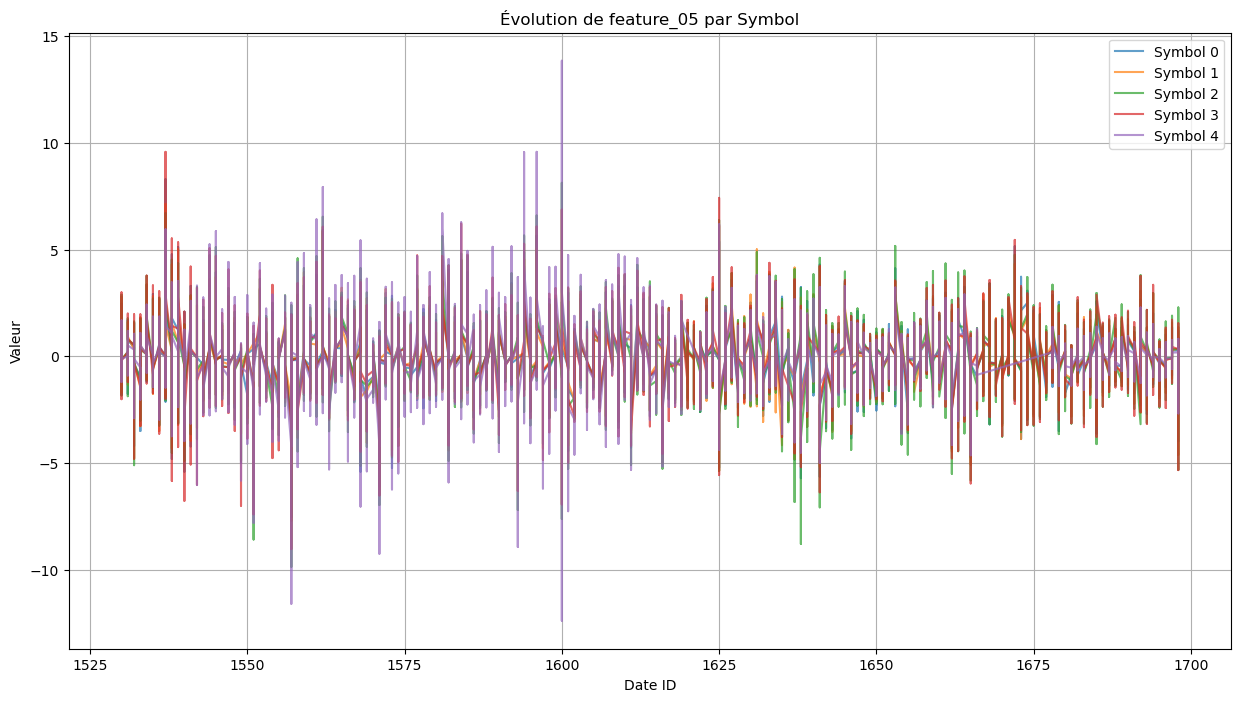

'\n# Pour voir les données d\'un symbol spécifique\nsymbol_id = 1\nprint(f"\nDonnées pour Symbol {symbol_id}:")\nprint(symbol_data[symbol_id].sort_values(\'date_id\').head())\n\n# Pour voir l\'évolution d\'une feature spécifique\nplot_feature_evolution(symbol_data, feature_name=\'feature_05\', n_symbols=3)\n\n# Pour voir les statistiques\nprint("\nStatistiques par symbol:")\nprint(stats.sort_values(\'n_dates\', ascending=False).head())\n'

In [4]:
# Exécuter l'analyse complète
symbol_data, stats = run_complete_analysis(df)

'''
# Pour voir les données d'un symbol spécifique
symbol_id = 1
print(f"\nDonnées pour Symbol {symbol_id}:")
print(symbol_data[symbol_id].sort_values('date_id').head())

# Pour voir l'évolution d'une feature spécifique
plot_feature_evolution(symbol_data, feature_name='feature_05', n_symbols=3)

# Pour voir les statistiques
print("\nStatistiques par symbol:")
print(stats.sort_values('n_dates', ascending=False).head())
'''

In [5]:
df_symbols = pd.concat(symbol_data.values(), ignore_index=True).sort_values(['symbol_id', 'date_id']).reset_index(drop=True)

In [ ]:
def create_symbol_datasets(df, base_path="C:/Users/srabh/Downloads/janestreettest"):
    """
    Creates separate datasets for each financial product (symbol_id),
    with all time series data in a single CSV file.
    
    Args:
        df: pandas DataFrame containing the data
        base_path: base directory where datasets will be stored
    """
    # Create base directory if it doesn't exist
    if not os.path.exists(base_path):
        os.makedirs(base_path)
    
    # Get unique symbol_ids
    symbol_ids = df['symbol_id'].unique()
    
    # Process each symbol_id (financial product)
    for symbol_id in symbol_ids:
        # Create directory for this symbol
        symbol_dir = os.path.join(base_path, str(symbol_id))
        if not os.path.exists(symbol_dir):
            os.makedirs(symbol_dir)
        # Get all data for this symbol and sort by time
        symbol_data = df[df['symbol_id'] == symbol_id].sort_values('time_id')
        
        # Save all data for this symbol in a single file
        file_path = os.path.join(symbol_dir, str(symbol_id) + '.csv')
        symbol_data.to_csv(file_path, index=False)
        
        print(f"Created dataset for symbol_id {symbol_id} with {len(symbol_data)} rows")

In [ ]:
create_symbol_datasets(df_symbols, base_path="C:/Users/srabh/Downloads/janestreetpartition9")